In [12]:
import numpy as np
import pandas as pd
import os
import tomli
import glob
import torch
import random
from torch.utils.data import DataLoader, Dataset, IterableDataset

In [2]:
with open("config.toml", "rb") as f:
    config = tomli.load(f)

In [3]:
corpus = "MSPPODCAST"
corpus_path = config[corpus]["PATH_TO_LABEL"]
corpus_df = pd.read_csv(corpus_path)
corpus_df["FileName"]= corpus_df["FileName"].str.replace('.wav', '')

In [4]:
corpus_df.head()

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039,N,4.0,4.2,4.2,127,Female,Development
2,MSP-PODCAST_0002_0051,N,4.0,4.2,4.2,127,Female,Development
3,MSP-PODCAST_0002_0059,X,4.0,3.8,4.0,128,Female,Development
4,MSP-PODCAST_0002_0061,F,3.4,2.8,4.2,128,Female,Development


In [5]:
# Remove non consensus labels
main_corpus_df = corpus_df[~corpus_df["EmoClass"].isin(["X", "O"])]

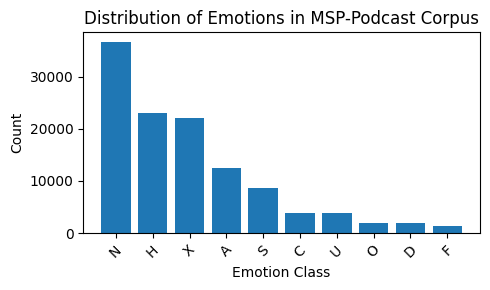


Emotion Distribution:
EmoClass
N    36666
H    23061
X    21993
A    12567
S     8647
C     3954
U     3935
O     1978
D     1974
F     1446
Name: count, dtype: int64


In [71]:
# Create a bar chart showing emotion distribution
import matplotlib.pyplot as plt

emotion_counts = corpus_df['EmoClass'].value_counts()
plt.figure(figsize=(5,3))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions in MSP-Podcast Corpus')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print actual counts
print("\nEmotion Distribution:")
print(emotion_counts)

In [30]:
# get test data
# total_audio = glob.glob(f"{config[corpus]['PATH_TO_AUDIO']}/*.wav")
# total_audio = [os.path.basename(x).replace('.wav', '') for x in total_audio]
# test_audio = [x for x in total_audio if x not in corpus_df["FileName"].values]

In [6]:
train_df = main_corpus_df[corpus_df["Split_Set"] == "Train"]
dev_df = main_corpus_df[corpus_df["Split_Set"] == "Development"]
test_df = pd.read_csv(config[corpus]["PATH_TO_TEST"])

/tmp/ipykernel_2133320/1103878050.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = main_corpus_df[corpus_df["Split_Set"] == "Train"]
/tmp/ipykernel_2133320/1103878050.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dev_df = main_corpus_df[corpus_df["Split_Set"] == "Development"]


In [7]:
def onehot_MSPPODCAST(emotion):
    # emotions = ["Angry", "Sad", "Happy", "Surprise", "Fear", "Disgust", "Contempt", "Neutral"]
    emotion_codes = ["A", "S", "H", "U", "F", "D", "C", "N"]
    one_hot_dict = {e: [1.0 if e == ec else 0.0 for ec in emotion_codes] for e in emotion_codes}
    return one_hot_dict[emotion]

In [13]:
class CustomDataset(IterableDataset):
    def __init__(self, df, text_path, audio_path, transform=None,seed=42):
        super(CustomDataset).__init__()
        self.df = df
        self.text_path = text_path
        self.audio_path = audio_path
        self.transform = transform
        self.seed = seed

        # Total length for worker distribution
        self.total_samples = len(self.df)

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        df = self.df
        if worker_info:
            per_worker = self.total_samples // worker_info.num_workers
            worker_id = worker_info.id

            # Set the random shuffle
            rng = random.Random(self.seed + worker_id)
            indices = list(range(len(df)))
            rng.shuffle(indices)

            # Set the start and end indices for the worker
            start_idx = worker_id * per_worker
            end_idx = start_idx + per_worker if worker_id < worker_info.num_workers - 1 else None

        for idx in indices[start_idx:end_idx]:
            row = df.iloc[idx]
            try:
                data = self._load_data(row, self.text_path, self.audio_path)
                if self.transform:
                    data = self.transform(data)
                yield data
            except Exception as e:
                print(f"Error loading file: {e}")
                continue
    def _load_data(self, row, text_path, audio_path):
        name = row["FileName"]
        text_features = np.load(os.path.join(text_path, name + ".npy"))
        audio_features = np.load(os.path.join(audio_path, name + ".npy"))
        category = onehot_MSPPODCAST(row["EmoClass"])
        avd = [row['EmoAct'],row['EmoVal'],row['EmoDom']]
        data = {
            "text": torch.tensor(text_features),
            "audio": torch.tensor(audio_features),
        }
        label = {
            "category": torch.tensor(category),
            "avd": torch.tensor(avd)
        }
        return data, label


In [9]:
def get_feature_dir(model):
    path = os.path.join(config[corpus]["PATH_TO_FEATURE"], model)
    assert os.path.exists(path), f"Feature directory {path} does not exist"
    return path

In [14]:
text_feature_extractor = 'roberta-base-UTT'
audio_feature_extractor = 'whisper-large-v3-UTT'
text_feature = get_feature_dir(text_feature_extractor)
audio_feature = get_feature_dir(audio_feature_extractor)

train_dataset = CustomDataset(train_df, text_feature, audio_feature)
valid_dataset = CustomDataset(dev_df, text_feature, audio_feature)

In [109]:
train_dataset.total_samples, valid_dataset.total_samples

(66992, 25258)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=16)
for batch_idx, (data, label) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(data['text'].shape)
    print(data['audio'].shape)
    print(label['category'].shape)
    print(label['avd'].shape)

In [ ]:
# Find optimal number of workers, best = 16
import time

def test_num_workers(dataset, num_workers_list):
    results = {}
    for num_workers in num_workers_list:
        dataloader = DataLoader(
            dataset,
            batch_size=32,
            num_workers=num_workers
        )
        
        start = time.time()
        for _ in dataloader:
            pass
        end = time.time()
        
        results[num_workers] = end - start
        
    return results

# Test different numbers of workers
workers_to_test = [0, 2, 4, 8, 16]
times = test_num_workers(train_dataset, workers_to_test)
# time
# {0: 2512.5396559238434,
#   2: 47.493666648864746,
#   4: 26.07319188117981,
#   8: 15.25866961479187,
#   16: 11.122616052627563},
# Find optimal setting
optimal_workers = min(times, key=times.get)

In [91]:
times, optimal_workers

({0: 2512.5396559238434,
  2: 47.493666648864746,
  4: 26.07319188117981,
  8: 15.25866961479187,
  16: 11.122616052627563},
 16)